In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

users_df = pd.read_csv('./data/total_registered_users_by_day.csv', parse_dates=['date'])
orders_df = pd.read_csv('./data/no_of_orders_by_day.csv', parse_dates=['date'])

final_df = pd.merge(users_df, orders_df, on='date')
final_df = final_df.sort_values(by='date')
final_df['day'] = final_df['date'].dt.day
final_df['month'] = final_df['date'].dt.month

scaler = MinMaxScaler()
final_df[['number_of_users', 'day', 'month', 'number_of_orders']] = scaler.fit_transform(
    final_df[['number_of_users', 'day', 'month', 'number_of_orders']]
)

In [32]:
sequence_length = 5

X = np.zeros((len(final_df) - sequence_length, sequence_length, 2))
y = np.zeros((len(final_df) - sequence_length, 1))
extra_features = np.zeros((len(final_df) - sequence_length, 2))

for i in range(len(final_df) - sequence_length):
    X[i] = final_df[['number_of_users', 'number_of_orders']].iloc[i:i+sequence_length].values
    y[i] = final_df[['number_of_orders']].iloc[i+sequence_length].values
    extra_features[i] = final_df[['day', 'month']].iloc[i + sequence_length].values


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_size = int(len(X) * 0.8)

X_train = torch.tensor(X[:train_size], dtype=torch.float32).to(device)
X_test = torch.tensor(X[train_size:], dtype=torch.float32).to(device)

extra_train = torch.tensor(extra_features[:train_size], dtype=torch.float32).to(device)
extra_test = torch.tensor(extra_features[train_size:], dtype=torch.float32).to(device)

y_train = torch.tensor(y[:train_size], dtype=torch.float32).squeeze().to(device)
y_test = torch.tensor(y[train_size:], dtype=torch.float32).squeeze().to(device)

input_size = X.shape[2]
hidden_size = 10
extra_size = extra_features.shape[1]
output_size = 1
batch_size = 32
num_epochs = 2
learning_rate = 0.0001

class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, extra_size, output_size, nhead=2, num_layers=2):
        super(TransformerModel, self).__init__()

        encoder_layer = nn.TransformerEncoderLayer(d_model=input_size, nhead=nhead, dim_feedforward=hidden_size)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.extra_fc = nn.Linear(extra_size, 8)

        self.combined_fc = nn.Linear(input_size + 8, output_size)

    def forward(self, x_seq, x_extra):
        x_seq = x_seq.transpose(0, 1)
        transformer_out = self.transformer_encoder(x_seq)

        transformer_feat = transformer_out[-1, :, :]

        extra_feat = torch.relu(self.extra_fc(x_extra))

        combined = torch.cat((transformer_feat, extra_feat), dim=1)

        return self.combined_fc(combined)

model = TransformerModel(input_size, hidden_size, extra_size, output_size).to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_dataset = TensorDataset(X_train, extra_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for X_batch, extra_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch, extra_batch).squeeze()
        loss = loss_function(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")


test_dataset = TensorDataset(X_test, extra_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, extra_batch, y_batch in test_loader:
        y_pred = model(X_batch, extra_batch).squeeze()
        all_preds.append(y_pred.cpu())
        all_targets.append(y_batch.cpu())

y_test_pred = torch.cat(all_preds)
y_test_true = torch.cat(all_targets)

test_loss = loss_function(y_test_pred, y_test_true)
print(f"Test Loss: {test_loss.item():.4f}")

C:\Users\serba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Test Loss: 0.0067


In [ ]:
print(y_train[:10])
print(y_test[:10])
print(torch.unique(y_test))


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0.1354, 0.1354, 0.1354, 0.1354, 0.1354, 0.1354, 0.1354, 0.1354, 0.1354,
        0.1354], device='cuda:0')
tensor([0.0000, 0.0014, 0.0027, 0.0041, 0.0055, 0.0068, 0.0082, 0.0096, 0.0123,
        0.0137, 0.0178, 0.0233, 0.0274, 0.0315, 0.0342, 0.0356, 0.0383, 0.0451,
        0.0465, 0.0479, 0.0492, 0.0547, 0.0561, 0.0629, 0.0711, 0.0739, 0.0876,
        0.0944, 0.1067, 0.1108, 0.1272, 0.1286, 0.1300, 0.1354, 0.1642, 0.1778,
        0.1792, 0.1943, 0.1956, 0.2312, 0.2750, 0.2777, 0.3707],
       device='cuda:0')


In [41]:
print(f"Length of test data: {len(y_test)}")
print(f"Length of predictions: {len(y_test_pred)}")

Length of test data: 69585
Length of predictions: 69585


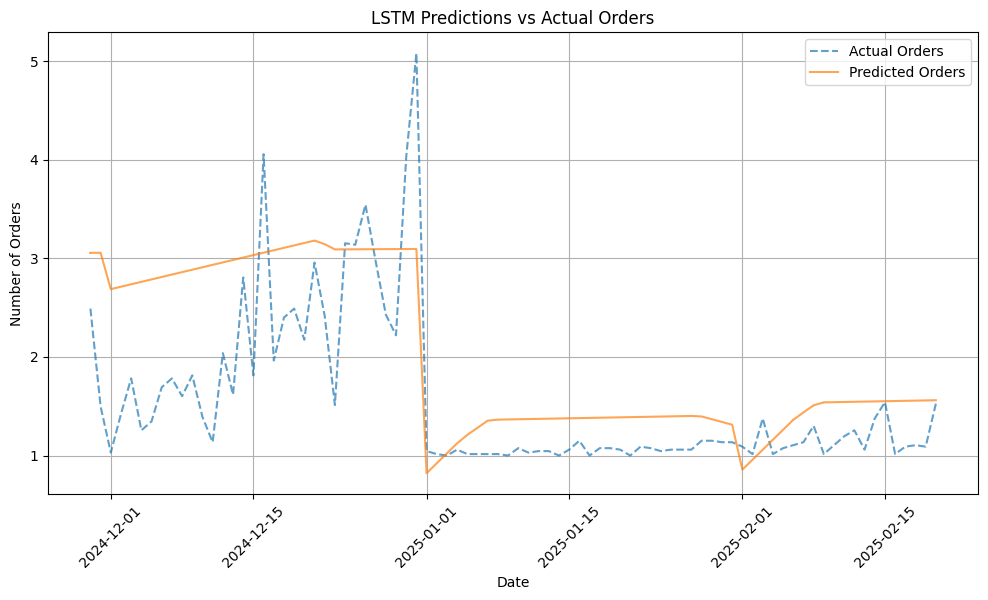

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

if isinstance(y_test_pred, torch.Tensor):
    y_test_pred = y_test_pred.cpu().detach().numpy()

if isinstance(y_test, torch.Tensor):
    y_test = y_test.cpu().detach().numpy()

y_test_pred = y_test_pred.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

num_features = scaler.scale_.shape[0]

target_index = 2

def pad_for_inverse_transform(pred_column, target_index=target_index):
    padded = np.zeros((len(pred_column), num_features))
    padded[:, target_index] = pred_column.flatten()
    return padded

y_test_pred_original = scaler.inverse_transform(pad_for_inverse_transform(y_test_pred))[:, target_index]
y_test_original = scaler.inverse_transform(pad_for_inverse_transform(y_test))[:, target_index]

test_dates = final_df['date'].iloc[-len(y_test):].values

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_original, label="Actual Orders", linestyle='dashed', alpha=0.7)
plt.plot(test_dates, y_test_pred_original, label="Predicted Orders", linestyle='solid', alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.title("LSTM Predictions vs Actual Orders")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


In [43]:
torch.save(model.state_dict(), './model/model.pth')

In [ ]:
import joblib

joblib.dump(scaler, 'model/scaler.pkl')

['model/scaler.pkl']